In [2]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameter setup

Plotting

In [3]:
inferno_r = matplotlib.cm.inferno_r
cmap_hist = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)

Saving

In [4]:
plot_dir = '../plots/2023-05-04_figures'
save = True

In [25]:
feature_label_dict = {'scalars_n3': 'Invariant scalar features',
                      'geos_n3': 'Geometric features',
                      'catalogz0': 'Standard halo features',
                      'mrv': r'$M_\mathrm{200m,FoF}, R_\mathrm{200m}, V_\mathrm{200m,FoF}$'}

In [37]:
feature_colors_dict = {'scalars_n3': 'black',
                      'geos_n3': 'maroon',
                      'catalogz0': 'lightseagreen',
                      'mrv': 'forestgreen'}

In [36]:
colors = ['forestgreen', 'lightseagreen', 'maroon', 'black']

## Load data

In [5]:
sim_name = 'TNG100-1'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
select_tag = ''

In [6]:
fn_select_config = f'../configs/halo_selection_{sim_name}{halo_tag}.yaml'
with open(fn_select_config, 'r') as file:
    select_params = yaml.safe_load(file)
tab_select = utils.load_table(select_params['select']['fn_select'])
print("N_select:", len(tab_select))

N_select: 31305


In [7]:
fn_halo_config = select_params['halo']['fn_halo_config']
with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)
tab_halos = utils.load_table(halo_params['halo']['fn_halos'])

In [8]:
sp = halo_params['sim']
sim_reader = SimulationReader(sp['base_dir'], sp['sim_name'], 
                              sp['sim_name_dark'], sp['snap_num_str'])

In [9]:
mass_multiplier = sim_reader.mass_multiplier
log_mass_shift = sim_reader.log_mass_shift

In [10]:
idxs_table = np.array(tab_select['idx_table'])

In [11]:
tab_halos_select = tab_halos[idxs_table]
print(len(tab_halos_select))

31305


In [12]:
frac_train, frac_val, frac_test = 0.7, 0.15, 0.15
random_ints = tab_select['rand_int']
idx_train, idx_valid, idx_test = utils.split_train_val_test(random_ints, 
                    frac_train=frac_train, frac_val=frac_val, frac_test=frac_test)

In [13]:
log_m200m = tab_halos['log_m200m_fof'][idxs_table]

Text(0, 0.5, 'number per bin')

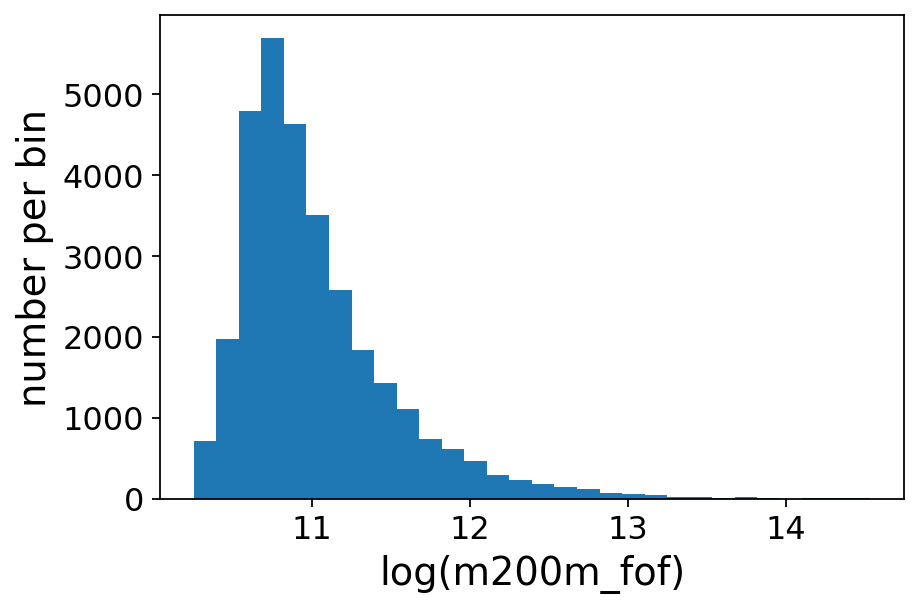

In [14]:
plt.hist(log_m200m, bins=30)
plt.xlabel('log(m200m_fof)')
plt.ylabel('number per bin')

In [15]:
tab_halos.columns

<TableColumns names=('idx_halo_dark','idx_subhalo_dark','idx_subhalo_hydro','idx_halo_hydro','m200m','r200m','v200m','x_com','x_grouppos','x_minPE','spin_subhalo','mstellar','rstellar','mgas','mbh','mbh_per_mstellar','sfr','sfr1','gband','gband_minus_iband','jstellar','m200m_hydro','npartstellar','npartgas','m200m_fof','r200m_fof','v200m_fof','m200m_fof_rmax','r200m_fof_rmax','v200m_fof_rmax','log_m200m','log_m200m_fof','log_m200m_hydro','log_mstellar','log_mgas','log_mbh','log_mbh_per_mstellar','log_rstellar','log_r200m','log_jstellar','log_ssfr','log_ssfr1','m200c','veldisp_subhalo','c200c','a_form','log_M200c_Msun_structure')>

#### colorbar normalization

In [16]:
frac_test = len(idx_test)/len(tab_select)
L_Mpc = sim_reader.box_size / 1000.0
weight = 1/(L_Mpc**3 * frac_test)
colorbar_label = 'galaxy number density'#+r'[$h^{-1}$ Mpc)$^{-3}$ dex$^{-2}$]'

#### fiducial model tag

In [17]:
model_tag = '_hgboost_yerrnan_epochs300_lr0.1'

# M stellar

In [17]:
x_label_name = 'log_m200m_fof'
y_label_name = 'log_mstellar'
fit_tag = f'_scalars_n3_{y_label_name}_hgboost_yerrnan_epochs300_lr0.1'
fn_model = f'../models/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

In [18]:
x_property = tab_halos_select[x_label_name][idx_test]

In [19]:
y_pred = np.load(fn_pred).ravel()

In [20]:
y = utils.load_labels([y_label_name], tab_halos, tab_select).ravel()
y_test = y[idx_test]

error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

(107597, 1)


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


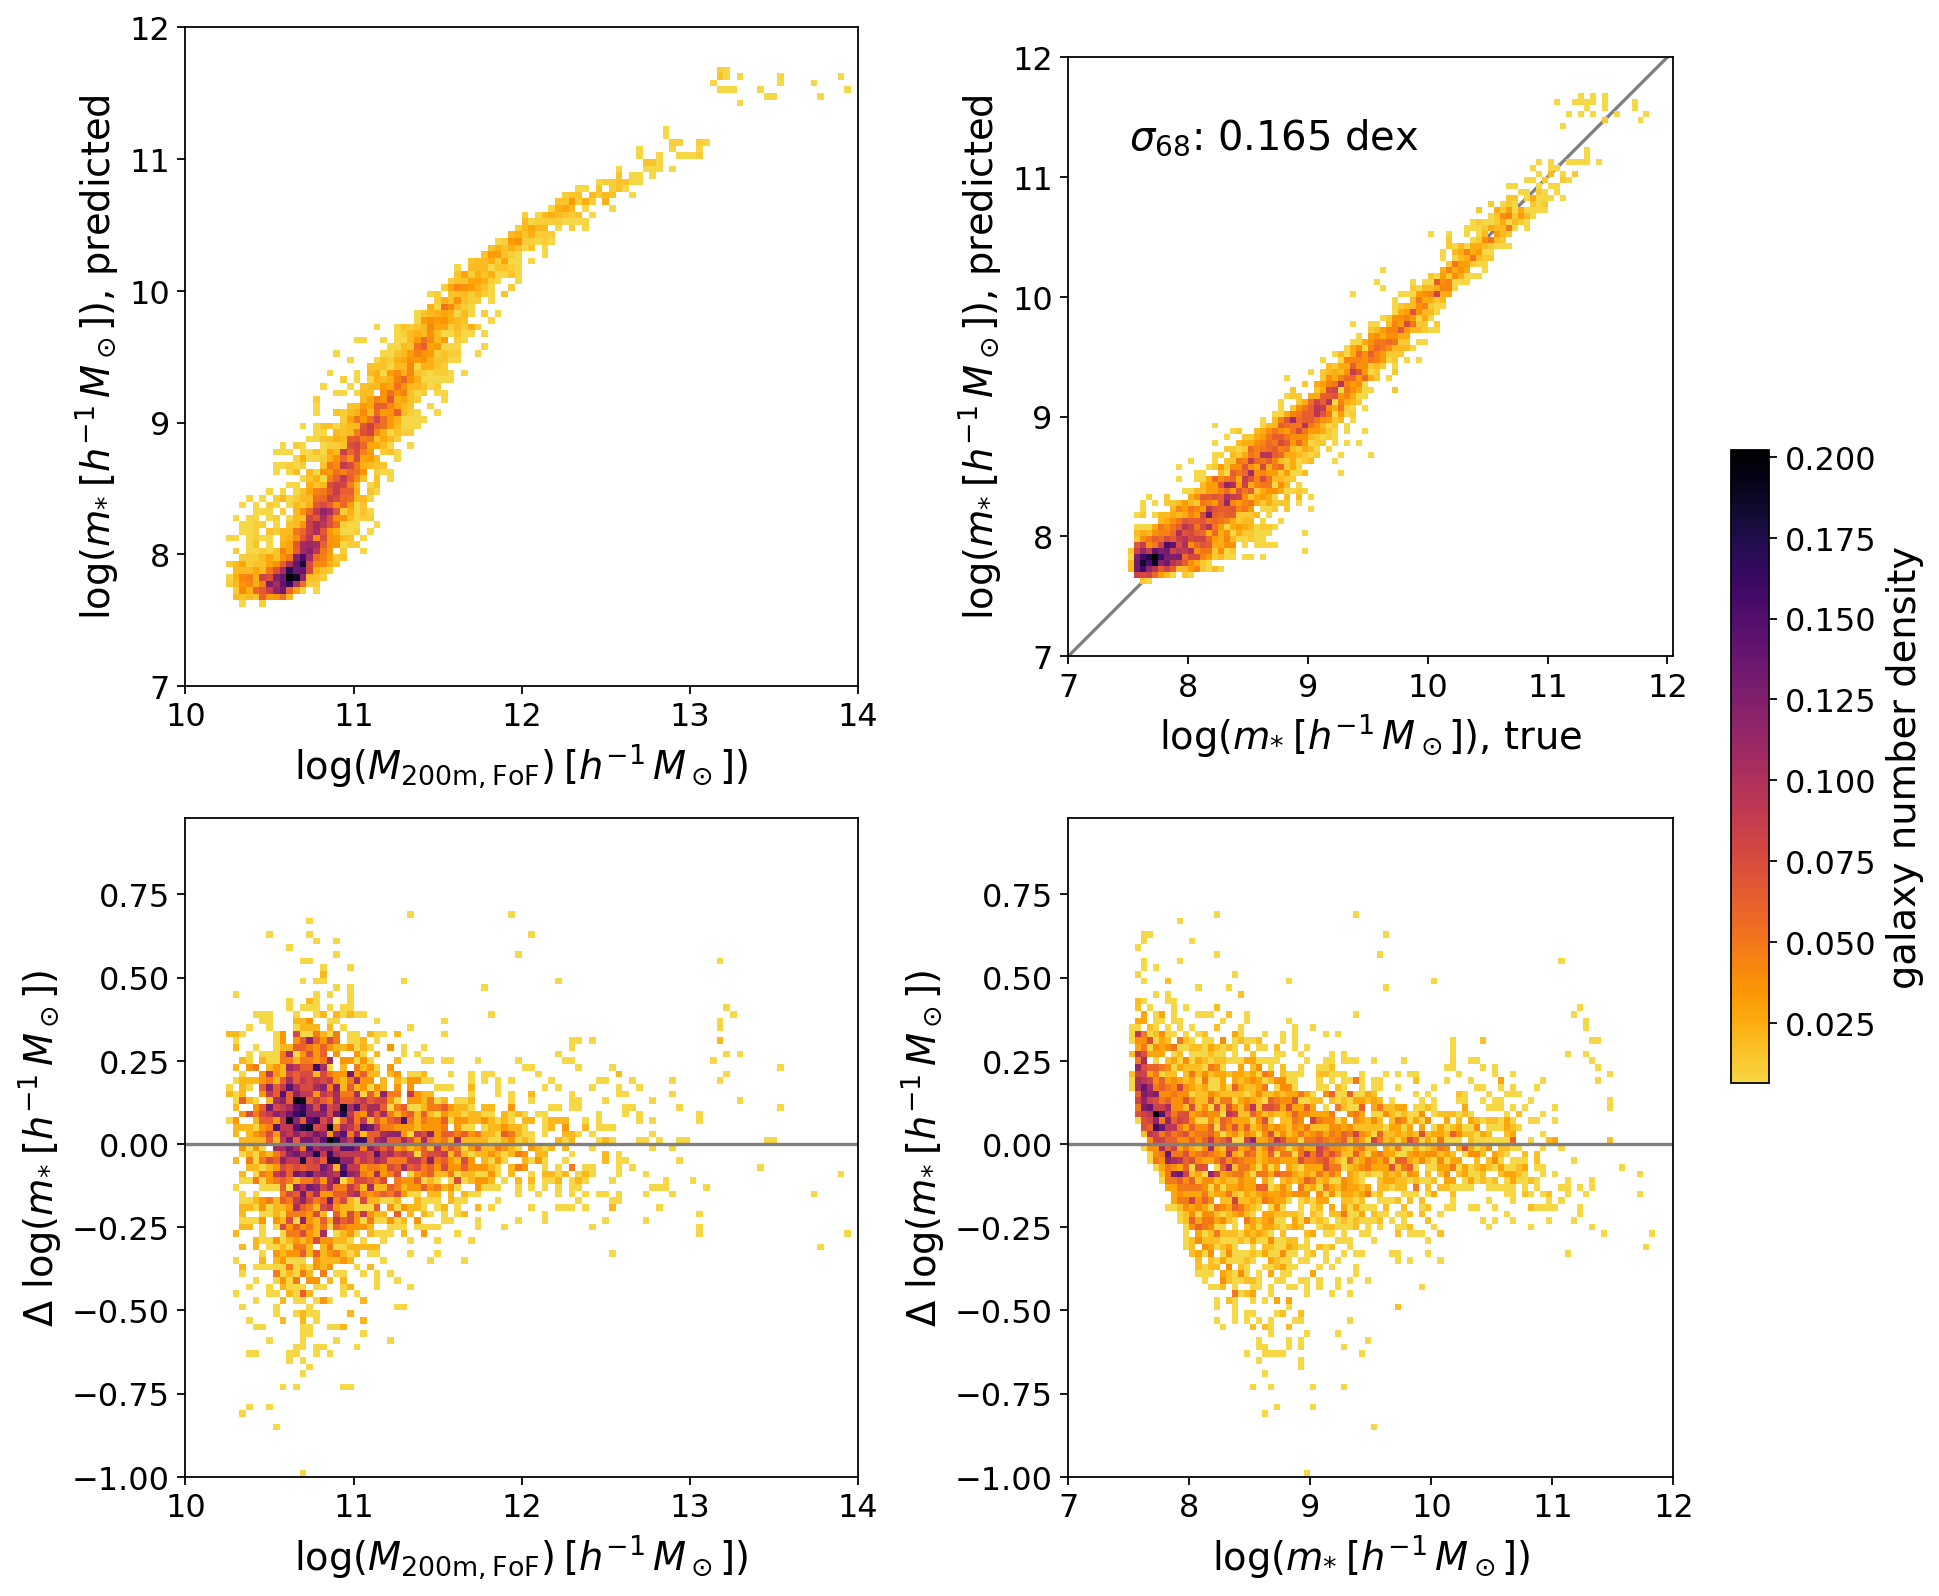

In [21]:
plotter.plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_test, y_pred, 
                              weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                              text_results=error_str)
fn = f'{plot_dir}/pred_mstellar.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# Feature plots for Mstellar

In [22]:
y_label_name = 'log_mstellar'
y = utils.load_labels([y_label_name], tab_halos, tab_select).ravel()
y_test = y[idx_test]

feature_modes = ['scalars_n3', 'geos_n3', 'catalogz0', 'mrv']
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]

#feature_modes = ['scalars', 'geos', 'catalog_z0']

(107597, 1)


In [24]:
y_pred_arr = []
text_results_arr = []
for i, feature_mode in enumerate(feature_modes):

    fit_tag = f'_{feature_mode}_{y_label_name}{model_tag}'

    fn_pred = f'../predictions/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    y_pred = np.load(fn_pred).ravel()
    
    y_pred_arr.append(y_pred)
    
    error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    text_results_arr.append(error_str)

In [25]:
def plot_multi_panel_pred_vs_true(n_rows, n_cols, y_label_name, y_true, y_pred_arr, cmap,
                                  text_results_arr=None, title_arr=None, save_fn=None,
                                  colors_test=None,
                                  weight=1, weight_by_dex=False,
                                  colorbar_label=''):
    fig, axarr = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12,12),
                              #gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [10, 9]},
                              )
    plt.subplots_adjust(hspace=0.4, wspace=0.33)
    
    inferno_r = matplotlib.cm.inferno_r
    cmap = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)
    
    count = 0
    for i in range(n_rows):
        for j in range(n_cols):
            #axarr[i,j].set_title(title_arr[count])
            axarr[i,j].set_title('hi!')
            
            h = plotter.plot_pred_vs_true_hist(axarr[i,j], y_label_name, y_true, y_pred_arr[count], cmap, 
                                       text_results=text_results_arr[count],
                                       weight=weight, weight_by_dex=weight_by_dex,
                                              title=title_arr[count])
            count += 1
    
    #ticks = np.arange(5, 25, 5)
    cax = fig.add_axes([0.93, 0.33, 0.02, 0.33])
    cbar = plt.colorbar(h[3], cax=cax, label=colorbar_label)#, ticks=ticks)
    #cbar.ax.set_yticklabels(ticks)


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


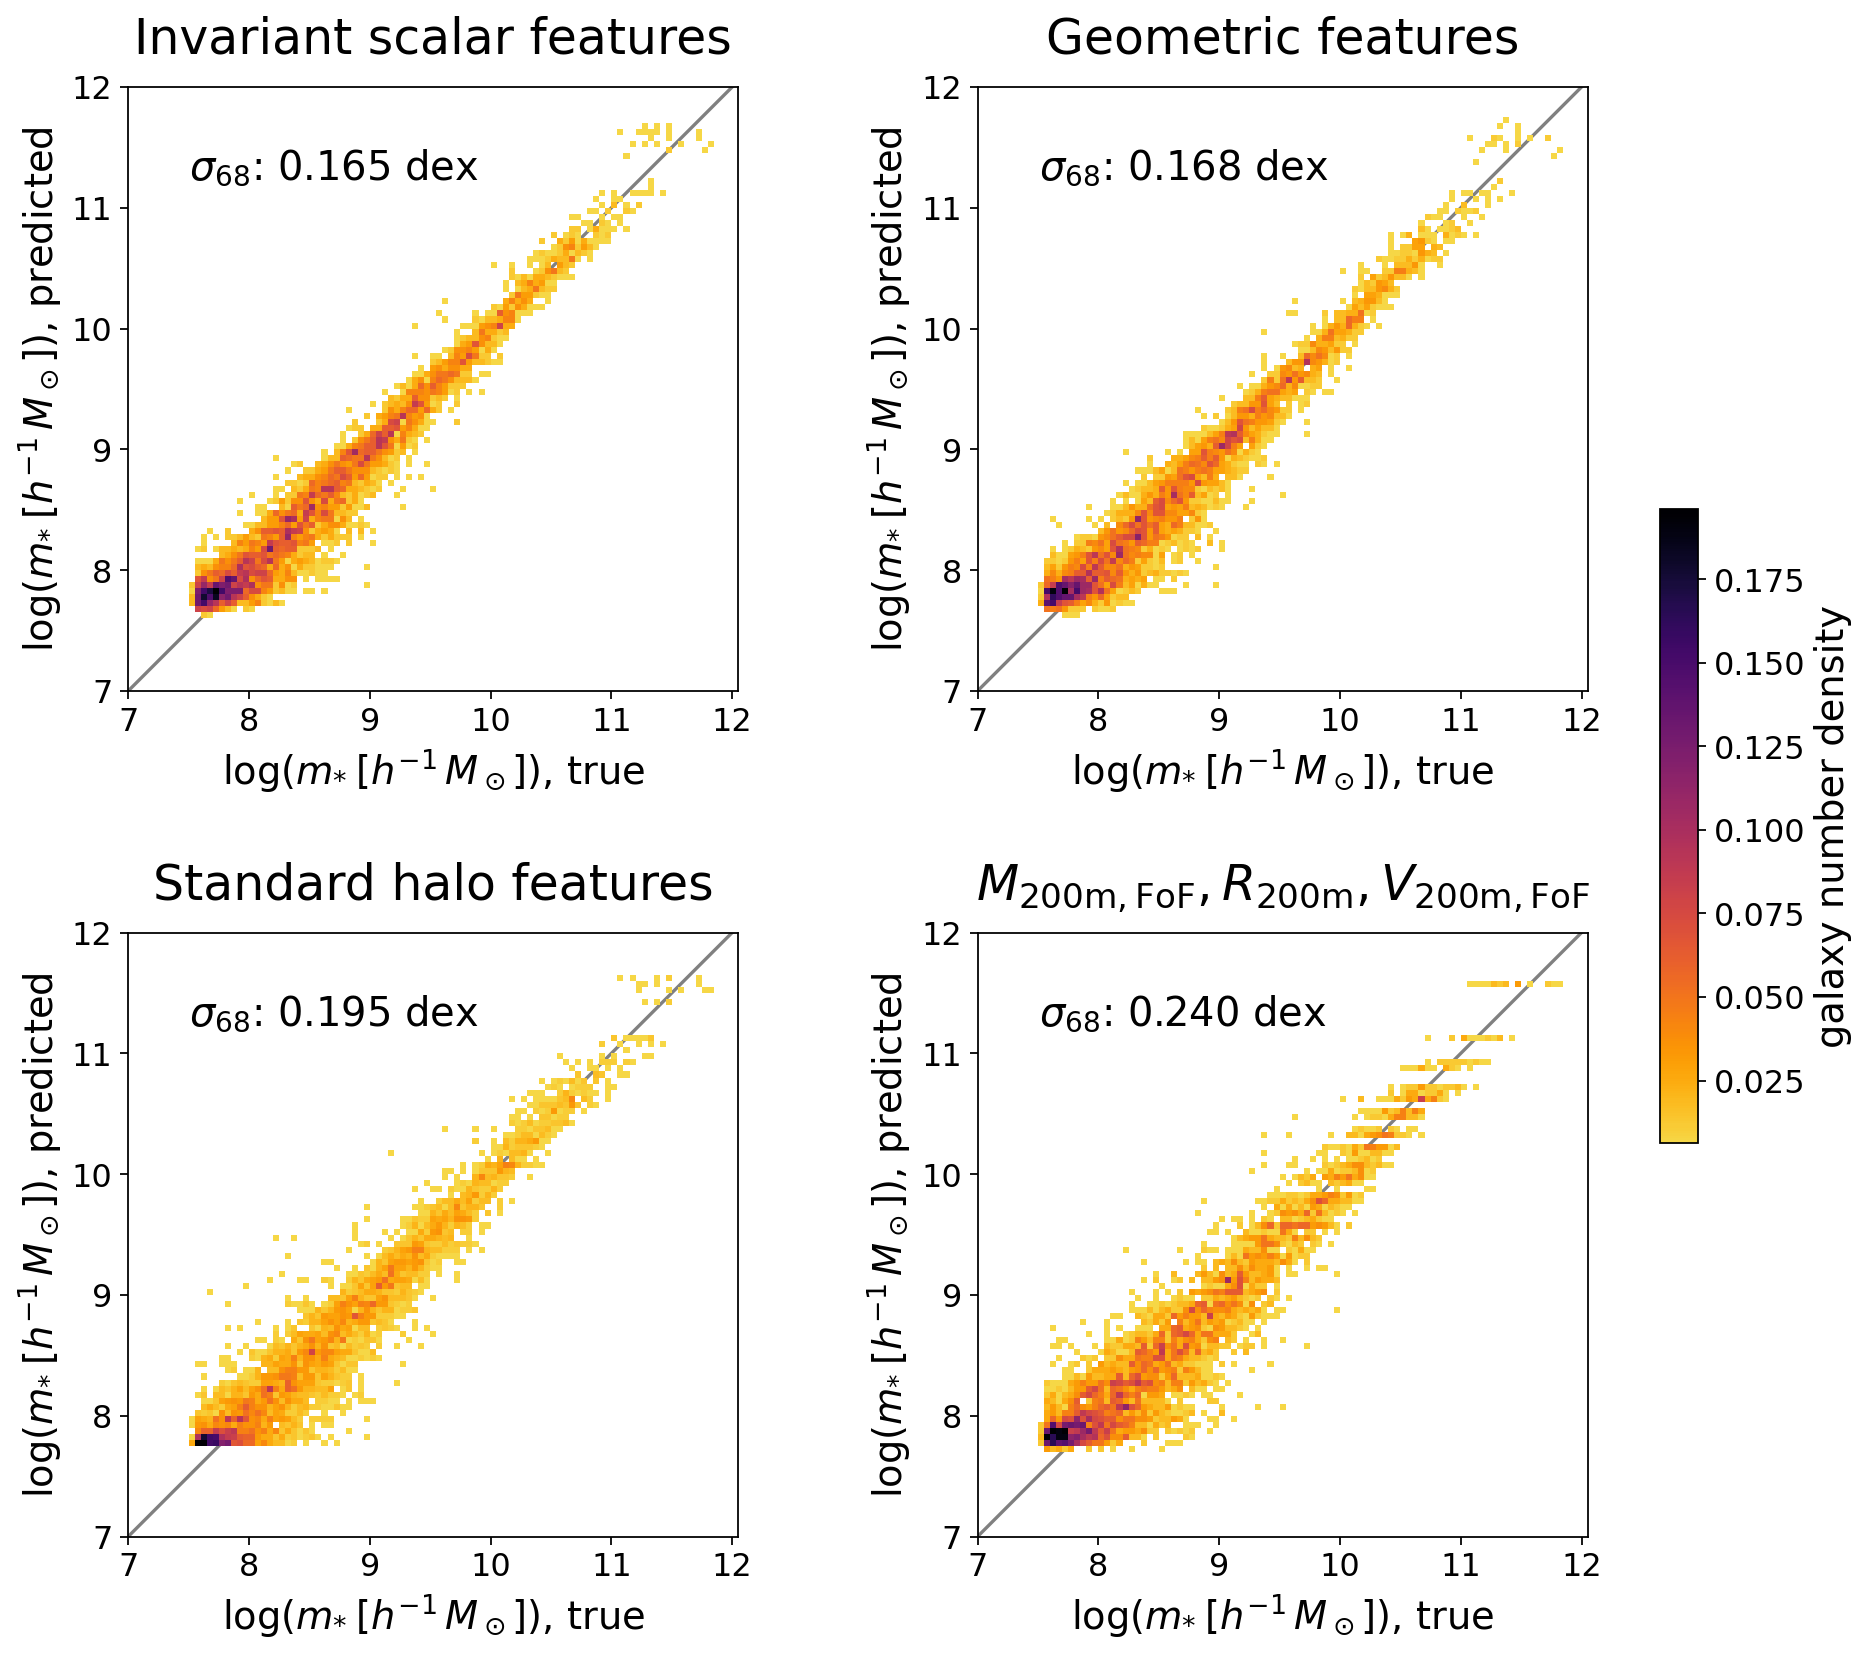

In [26]:
plot_multi_panel_pred_vs_true(2, 2, y_label_name, y_test, y_pred_arr, 
                             cmap_hist, text_results_arr=text_results_arr,
                            weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                             title_arr=feature_labels)
fn = f'{plot_dir}/feature_comparison_mstellar.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# Galaxy properties

In [27]:
mbh_zero = np.min(tab_halos['mbh'][tab_halos['mbh']!=0])/2.0  
print(mbh_zero)
print(np.log10(mbh_zero))

3.9999998989515007e-05
-4.397940019643239


In [28]:
np.min(tab_halos['log_mbh'])

5.60206

In [29]:
#feature_modes = ['scalars_n3', 'geos_n3', 'catalogz0', 'mrv']
feature_modes = ['mrv', 'catalogz0', 'geos_n3', 'scalars_n3']
# #feature_modes = ['scalars', 'catalog_z0', 'mrv']
#feature_modes = ['scalars_n3']
# #feature_modes = ['catalog_z0']
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]

In [30]:
x_label_name = 'log_m200m_fof'
label_tag = 'galprops'
y_label_names = utils.get_gal_prop_names(label_tag)
y_label_name_plot = y_label_names
print(y_label_names)

['log_mstellar', 'log_ssfr1', 'log_rstellar', 'log_jstellar', 'gband_minus_iband', 'log_mbh_per_mstellar']


In [31]:
x_property = tab_halos_select[x_label_name][idx_test]
x_bins = np.arange(10.25, 13.7501, 0.5)
print(x_bins)

[10.25 10.75 11.25 11.75 12.25 12.75 13.25 13.75]


In [32]:
y_true_arr = []
y_pred_arr = []
text_results_arr = []

j_fiducial = feature_modes.index('scalars_n3')
#j_fiducial = feature_modes.index('catalog_z0')

y_true_arr_all = utils.load_labels(y_label_names,
                               tab_halos, tab_select)
y_true_arr = y_true_arr_all[idx_test].T

y_pred_feat_arr = []
for j in range(len(feature_modes)):
    feature_mode = feature_modes[j]
    fit_tag = f'_{feature_mode}_{label_tag}{model_tag}'

    fn_model = f'../models/model_{sim_name}{halo_tag}{fit_tag}.pt'
    fn_pred = f'../predictions/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    y_pred_all = np.load(fn_pred)
    y_pred_feat_arr.append(np.atleast_2d(y_pred_all))
    
y_pred_feat_arr = np.array(y_pred_feat_arr)
print(y_pred_feat_arr.shape)

y_lowerlim_arr = []    
for y_label_name in y_label_name_plot:
    i = y_label_names.index(y_label_name)
    y_test = y_true_arr[i]
    y_pred = y_pred_feat_arr[j_fiducial,:,i]
    y_pred_feats = y_pred_feat_arr[:,:,i]
    error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    
    # not passing halo_logmass_min bc shy made same cut as our fiducial
    _, stdevs_binned = utils.get_butterfly_error(x_bins, y_label_name,
                                                      #halo_logmass_min=select_params['select']['halo_logmass_min'], 
                                                      #n_bins=10
                                                     )
    y_lowerlim_arr.append(stdevs_binned)
    
    #y_true_arr.append(y_test)
    y_pred_arr.append(y_pred_feats)
    text_results_arr.append(error_str)

# x_bins_avg same for all, we'll just grab the last one
y_pred_arr = np.array(y_pred_arr)
print(y_pred_arr.shape)
print(x_property.shape)
print(y_true_arr.shape)

(107597, 6)
(4, 4696, 6)
[10.25 10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[0.12963026192057495, 0.09972088820992024, 0.05248956168863052, 0.04303676740987745, 0.04399957824297352, 0.03538449745975384, 0.024326193135064383]
[10.25 10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[0.34671905980014467, 0.2580421508066805, 0.2639467882475131, 0.6605295703991253, 0.45579335183852243, 0.35053084392558054, 0.47429673846400167]
[10.25 10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[0.07537020984691599, 0.09319289728483247, 0.09330745520658, 0.07031006803826244, 0.06202353187386205, 0.10389925129095835, 0.031254839177015596]
[10.25 10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[0.20944992336208862, 0.19143562178947518, 0.18295570133597266, 0.1394925620338419, 0.14909354153313673, 0.1335955530714643, 0.11573762993988213]
[10.25 10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[0.18541556695650352, 0.1575222354898453, 0.12017155133224211, 0.11187672790237581, 0.0326087526858771, 0.06396773329400339, 0.101769781579

In [33]:
frac_test = len(idx_test)/len(tab_select)
L_Mpc = sim_reader.box_size / 1000.0
weight = 1/(L_Mpc**3 * frac_test)
colorbar_label = 'galaxy number density\n'+r'[$h^{-1}$ Mpc)$^{-3}$ dex$^{-2}$]'


In [34]:
#colors = ['black', 'maroon', 'lightseagreen', 'forestgreen']
colors = ['forestgreen', 'lightseagreen', 'maroon', 'black']

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


../plots/2023-05-04_figures/pred_galprops.png


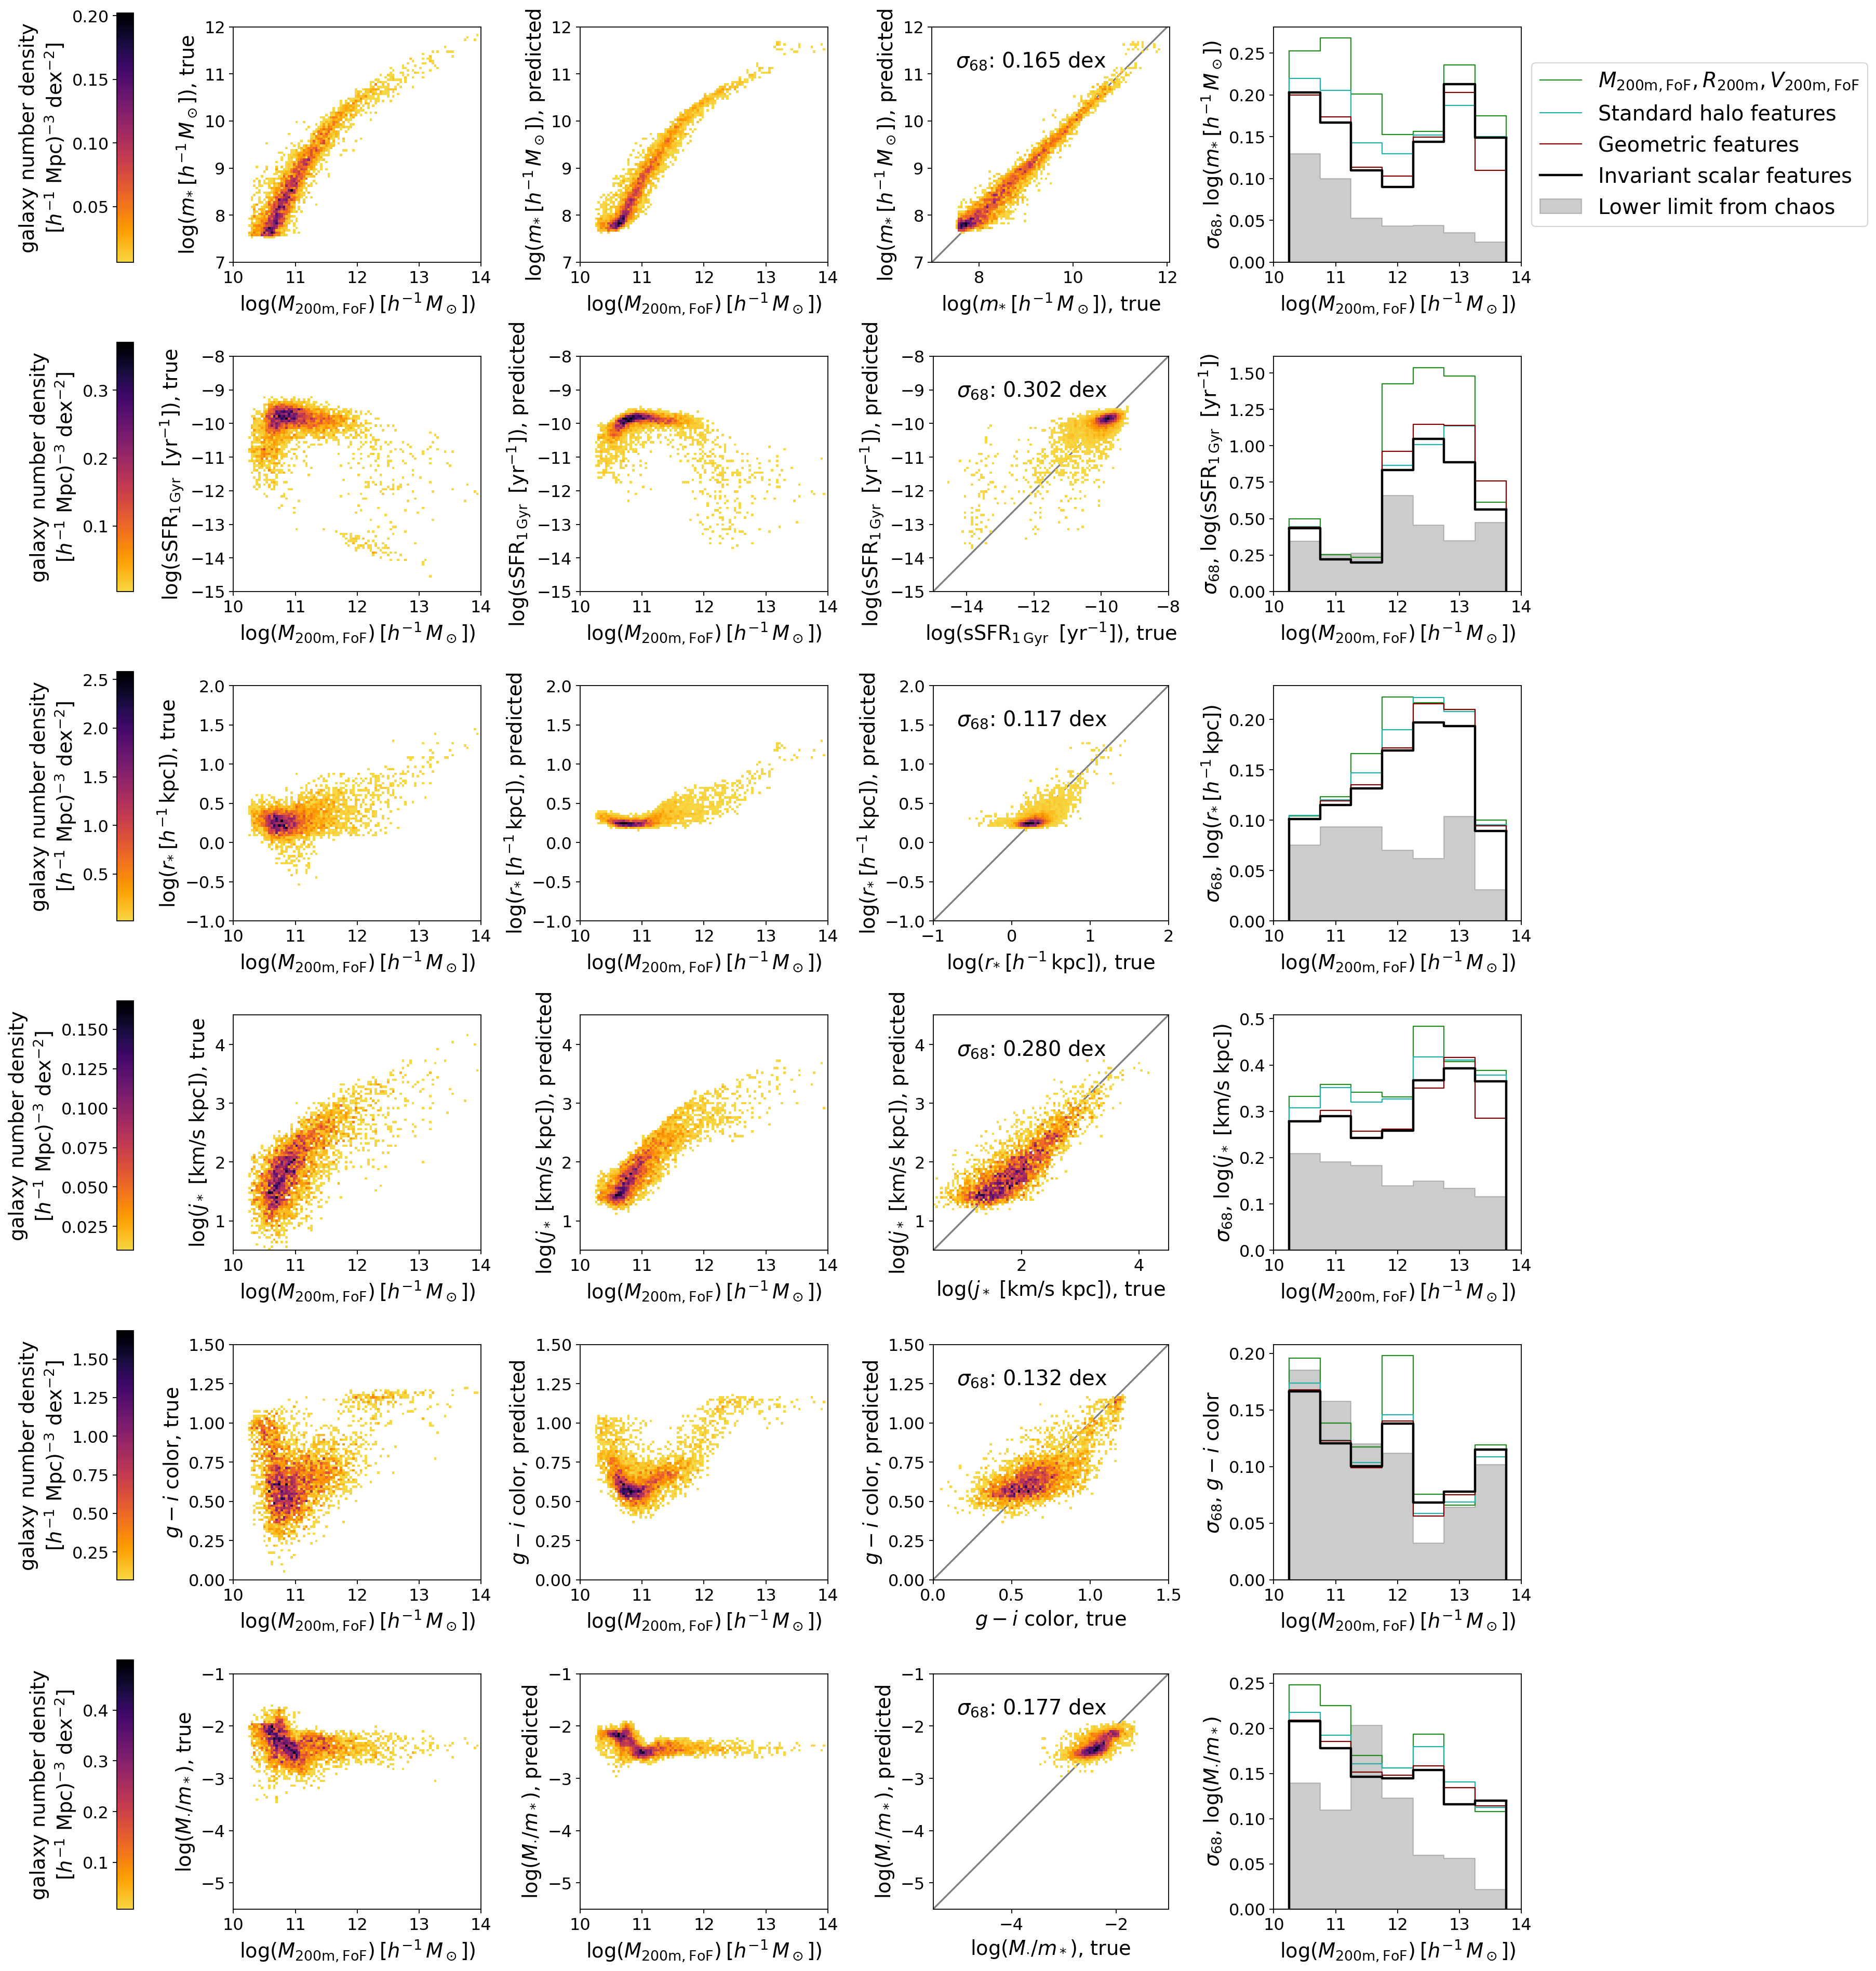

In [35]:
plotter.plot_multi_panel_gal_props_errors(x_label_name, y_label_name_plot, x_property, y_true_arr, y_pred_arr,
                                   feature_labels, colors,
                                   j_fiducial=j_fiducial,
                                   weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                                   text_results_arr=text_results_arr,
                                   x_bins=x_bins, y_lowerlim_arr=y_lowerlim_arr)
fn = f'{plot_dir}/pred_{label_tag}.png'
if save:
    print(fn)
    plt.savefig(fn, bbox_inches='tight')

# histograms

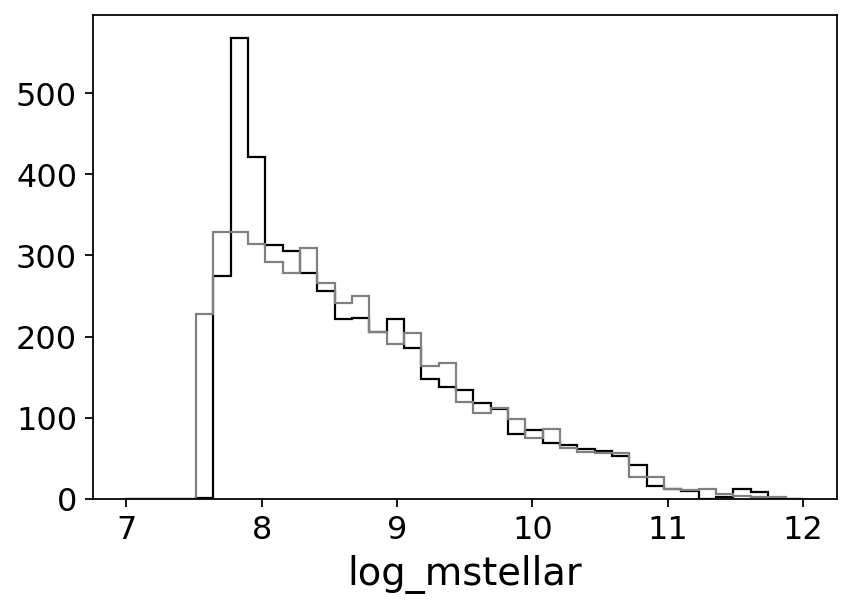

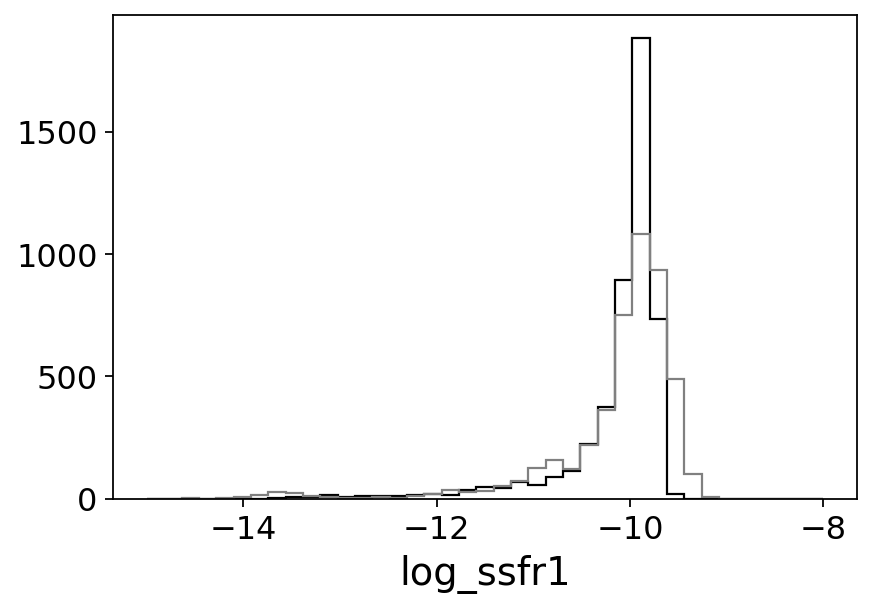

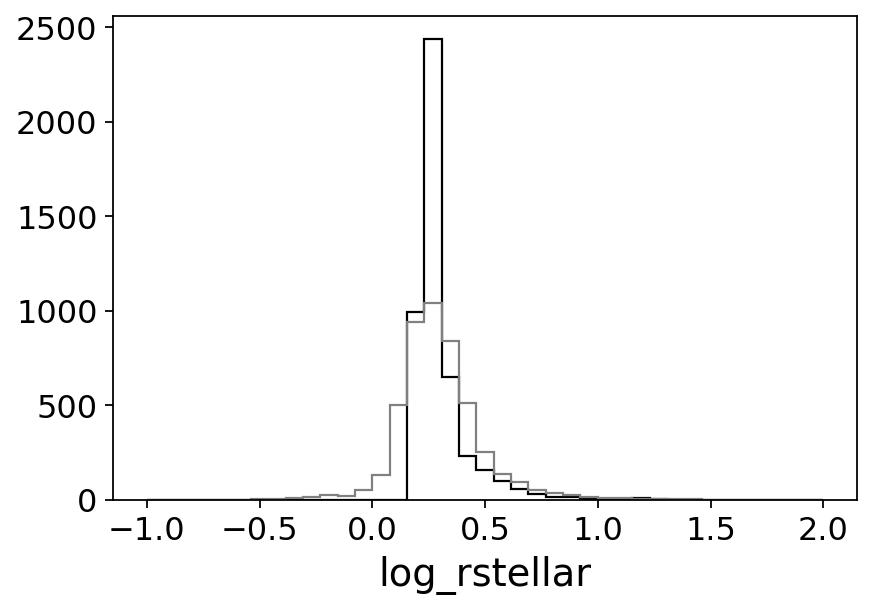

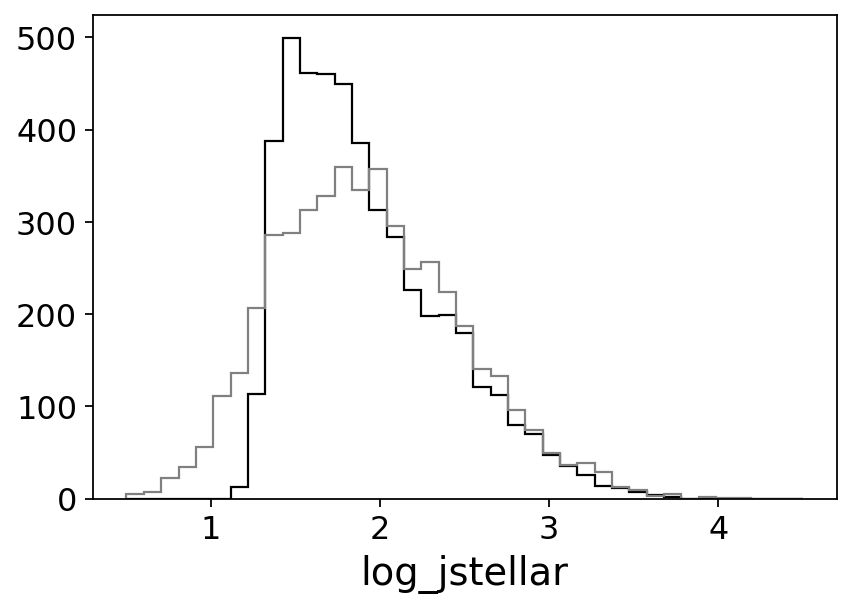

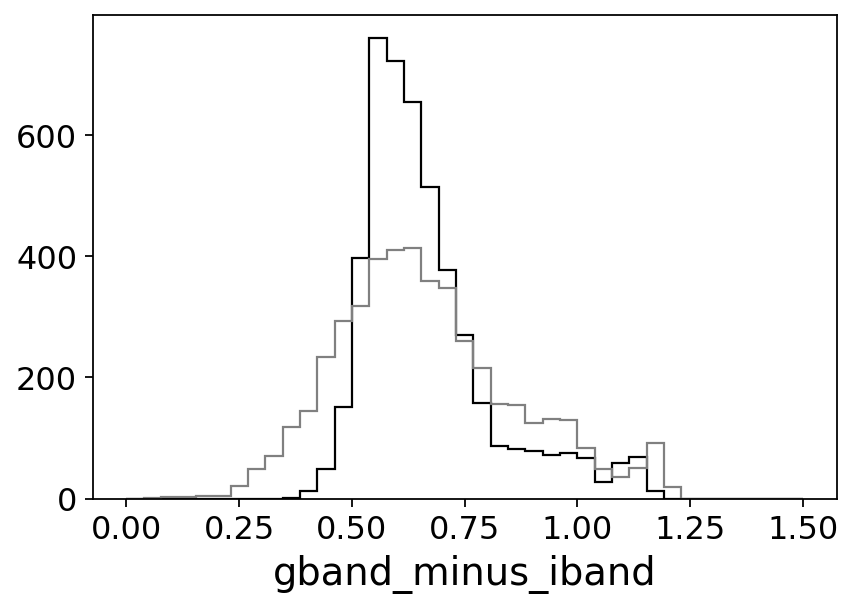

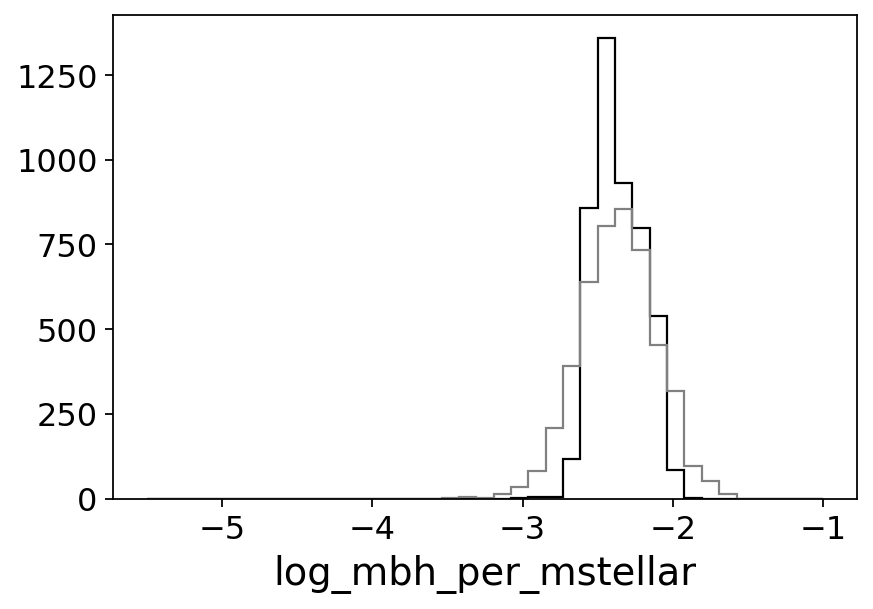

In [36]:
for y_label_name in y_label_name_plot:
    i = y_label_names.index(y_label_name)
    y_test = y_true_arr[i]
    y_pred = y_pred_feat_arr[j_fiducial,:,i]
    y_pred_feats = y_pred_feat_arr[:,:,i]
    plt.figure()
    bins = np.linspace(*utils.lim_dict[y_label_name], 40)
    plt.hist(y_pred, bins=bins, histtype='step', color='black')
    plt.hist(y_test, bins=bins, histtype='step', color='grey')
    plt.xlabel(y_label_name)

# Mass Assembly History

In [89]:
y_label_name = 'amfracs'
feature_mode = 'scalars_n3'
fit_tag = f'_{feature_mode}_{y_label_name}{model_tag}'
fn_amfrac = f'../data/mahs/amfracs_{sim_name}{halo_tag}.fits'
fn_model = f'../models/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
# fn_amfrac = f'../data/mahs/amfracs_{sim_name}_mini10.fits'
# fn_model = f'../models/model_{sim_name}_mini10{fit_tag}.pt'
# fn_pred = f'../predictions/predictions_{sim_name}_mini10{fit_tag}.npy'

In [90]:
y_pred = np.load(fn_pred)
print(y_pred.shape)

(4696, 39)


In [257]:
y = utils.load_labels(y_label_name, tab_halos, tab_select, fn_amfrac=fn_amfrac)
y_test = y[idx_test]
y_train = y[idx_train]

(107597, 39)
(107597, 39)


In [92]:
tab_amfrac = utils.load_table(fn_amfrac)
mfrac_vals = [float(c) for c in tab_amfrac.columns if c!='idx_halo_dark']

### look at mass histories

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


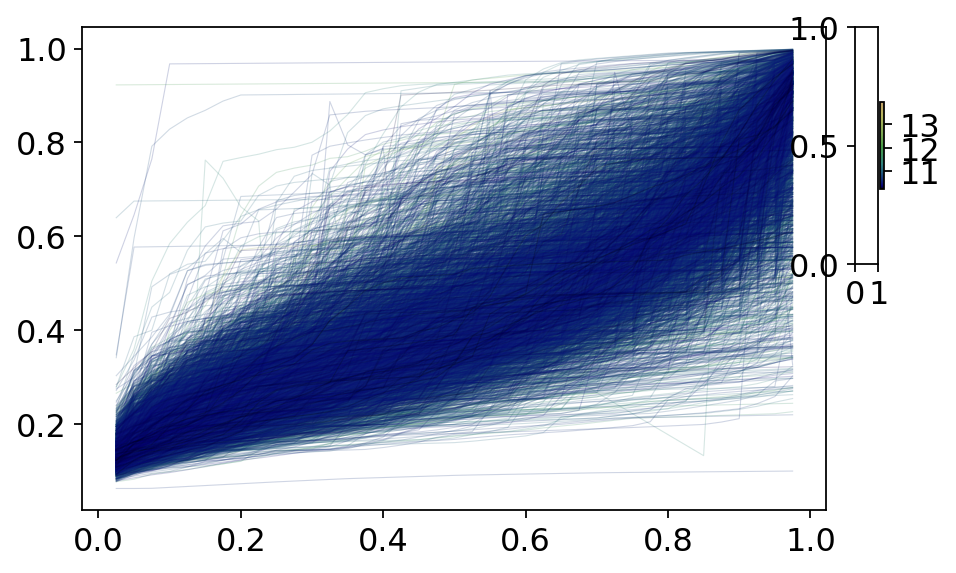

In [127]:
x_label_name = 'log_m200m_fof'
x_property = tab_halos_select[x_label_name][idx_test]

idxs_show = np.arange(len(idx_test))
n_show = len(idxs_show)
locs_norm = matplotlib.colors.Normalize(vmin=np.min(x_property),
                                        vmax=np.max(x_property))
cmap_orig = matplotlib.cm.get_cmap('gist_earth')
cmap = utils.shiftedColorMap(cmap_orig, start=0,
                    midpoint=0.4, stop=0.8)
colors = [cmap(locs_norm(x)) for x in x_property]

fig = plt.figure(figsize=(6, 4))
ax0 = plt.gca()

i_shuffle = rng.choice(np.arange(len(idxs_show)), size=len(idxs_show), replace=False)

for i, idx_show in enumerate(idxs_show[i_shuffle]):

    label_true, label_pred = None, None
    if i==0:
        label_true = 'true value'
        label_pred = 'predicted value'

    #ax0.plot(mfracs, a_true[idx_show], marker='o', markersize=2, ls='None', color=colors[i], label=label_true)
    ax0.plot(mfrac_vals, y_test[idx_show], color=colors[i], label=label_pred, lw=0.5, alpha=0.2)
    
#fig.colorbar(ax0, cmap=cmap, norm=locs_norm)
cax = fig.add_axes([0.93, 0.51, 0.03, 0.37])
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
#sm.set_clim(0.1, 0.6)
#cbar = fig.colorbar(sm, cax=cax, shrink=0.7, pad=0.04)
fig.colorbar(sm)
cbar.set_label(label_show)

In [255]:
x_label_name = 'log_m200m_fof'
x_property = tab_halos_select[x_label_name][idx_test]
m_bins = np.linspace(np.min(x_property), np.max(x_property), 8)
print(m_bins)
idxs_show = []
rng = np.random.default_rng(seed=47)
idxs = np.arange(len(x_property))
y_means = []
y_stds = []
x_means = []
for bb in range(len(m_bins)-1):
    i_inbin = (x_property >= m_bins[bb]) & (x_property < m_bins[bb+1])
    x_means.append( np.log10(np.mean(10**x_property[i_inbin])) )
    y_mean = np.mean(y_test[i_inbin], axis=0)
    y_means.append(y_mean)
    y_std = np.std(y_test[i_inbin], axis=0)
    y_stds.append(y_std)
print(x_means)
label_show = utils.label_dict[x_label_name]
print(label_show)

[10.25885411 10.78386759 11.30888108 11.83389456 12.35890805 12.88392153
 13.40893502 13.9339485 ]
[10.630999384821951, 11.023880552317888, 11.545970971746, 12.092099517281667, 12.585850587189833, 13.10959661586964, 13.64713227151108]
log($M_\mathrm{200m,FoF}) \: [h^{-1} \, M_\odot]$)


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


(0.0, 1.0)

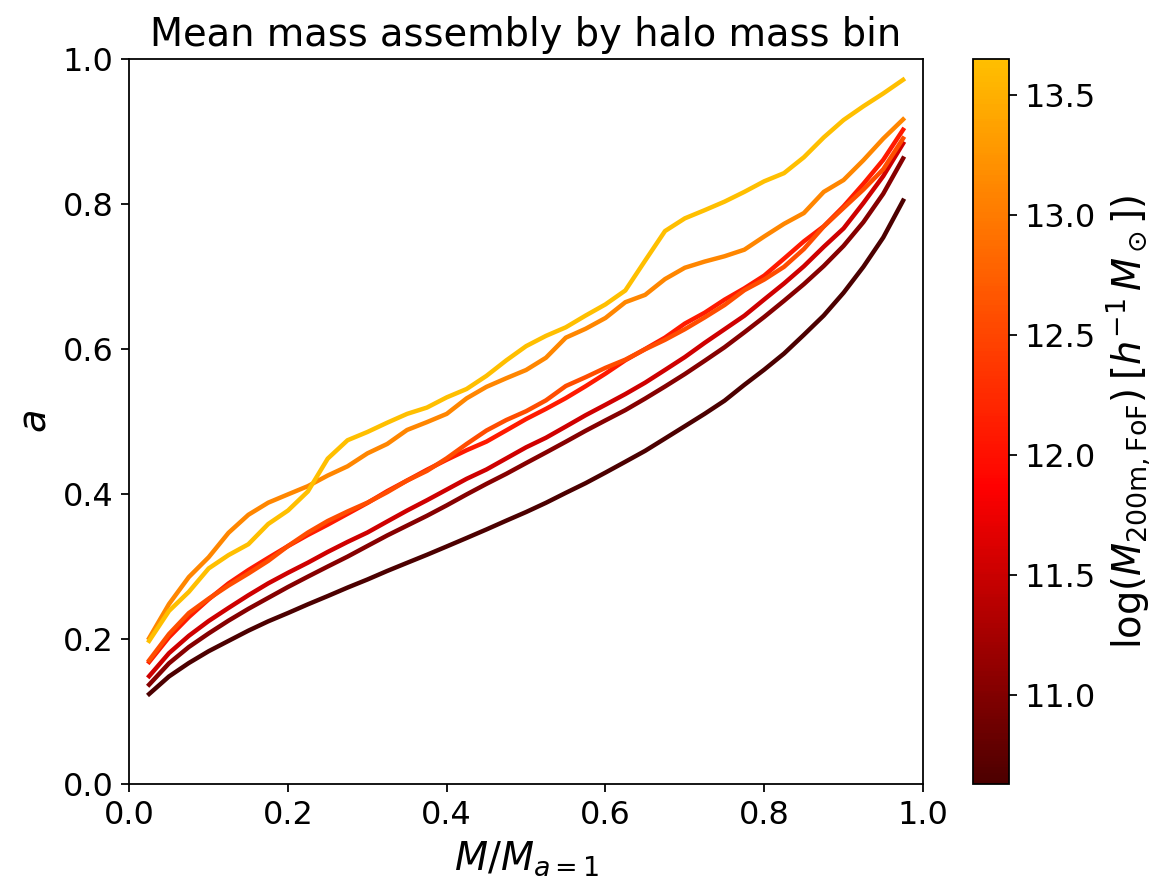

In [256]:
x_label_name = 'log_m200m_fof'
x_property = tab_halos_select[x_label_name][idx_test]

locs_norm = matplotlib.colors.Normalize(vmin=np.min(x_means),
                                        vmax=np.max(x_means))
cmap_orig = matplotlib.cm.get_cmap('hot')
cmap = utils.shiftedColorMap(cmap_orig, start=0.1,
                    midpoint=0.425, stop=0.65)
colors = [cmap(locs_norm(x)) for x in x_means]

fig = plt.figure(figsize=(8, 6))
ax0 = plt.gca()

i_shuffle = rng.choice(np.arange(len(idxs_show)), size=len(idxs_show), replace=False)

for i in range(len(y_means)):

    label_true, label_pred = None, None
    if i==0:
        label_true = 'true value'
        label_pred = 'predicted value'

    ax0.plot(mfrac_vals, y_means[i], color=colors[i], label=label_pred, lw=2, alpha=1)
#     ax0.fill_between(mfrac_vals, y_means[i]-y_stds[i], y_means[i]+y_stds[i], 
#                      color=colors[i], label=label_pred, lw=0, alpha=0.4)
    
#fig.colorbar(ax0, cmap=cmap, norm=locs_norm)
#cax = fig.add_axes([0.93, 0.51, 0.03, 0.37])
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
#sm.set_clim(0.1, 0.6)
#cbar = fig.colorbar(sm, cax=cax, shrink=0.7, pad=0.04)
fig.colorbar(sm, label=label_show)
#cbar.set_label(label_show)
plt.xlabel(r'$M/M_{a=1}$')
plt.ylabel(r'$a$')

plt.title("Mean mass assembly by halo mass bin")
plt.xlim(0, 1)
plt.ylim(0, 1)

### multi-panel plot

In [259]:
x_label_name = 'log_m200m_fof'
x_property = tab_halos_select[x_label_name][idx_test]
m_bins = np.linspace(np.min(x_property), np.max(x_property), 5)
print(m_bins)
idxs_show = []
rng = np.random.default_rng(seed=47)
idxs = np.arange(len(x_property))
for bb in range(len(m_bins)-1):
    i_inbin = (x_property >= m_bins[bb]) & (x_property < m_bins[bb+1])
    idxs_show.append( rng.choice(idxs[i_inbin]) )
#         if (x_property[i] >= m_bins[bb]) & (x_property[i] < m_bins[bb+1]):
#             idxs_show.append(i)
#             break
print(idxs_show)
print(x_property[idxs_show])
label_show = utils.label_dict[x_label_name]
print(label_show)

[10.25885411 11.17762771 12.09640131 13.0151749  13.9339485 ]
[1636, 1027, 125, 23]
  log_m200m_fof   
------------------
11.088354575537416
11.313220212784282
 12.35011923426313
13.137417678005095
log($M_\mathrm{200m,FoF}) \: [h^{-1} \, M_\odot]$)


### with other feature sets

In [260]:
feature_modes = ['mrv', 'catalogz0', 'geos_n3', 'scalars_n3']
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]
j_fiducial = feature_modes.index('scalars_n3')

In [261]:
lws = np.full(len(feature_modes), 1.5)
lws[j_fiducial] = 2.5
feature_colors = [feature_colors_dict[fm] for fm in feature_modes]

In [262]:
y_label_arr = []
title_arr = []
y_pred_arr = []

y_pred_mtarget_arr = []
for i, feature_mode in enumerate(feature_modes):
    fit_tag = f'_{feature_mode}_{y_label_name}{model_tag}'
    fn_pred = f'../predictions/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    y_pred = np.load(fn_pred)
    y_pred_arr.append(y_pred)    

y_label_arr.append( rf'$a(M/M_{{a=1}})$')
title_arr.append(rf'$M/M_{{a=1}} = {mfrac_target}$')

y_pred_arr = np.array(y_pred_arr)
print(y_pred_arr.shape)
print(y_test.shape)

(4, 4696, 39)
(4696, 39)


Bbox(x0=0.125, y0=0.583921568627451, x1=0.9, y1=0.88)
Bbox(x0=0.125, y0=0.42848039215686284, x1=0.9, y1=0.5765196078431374)


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


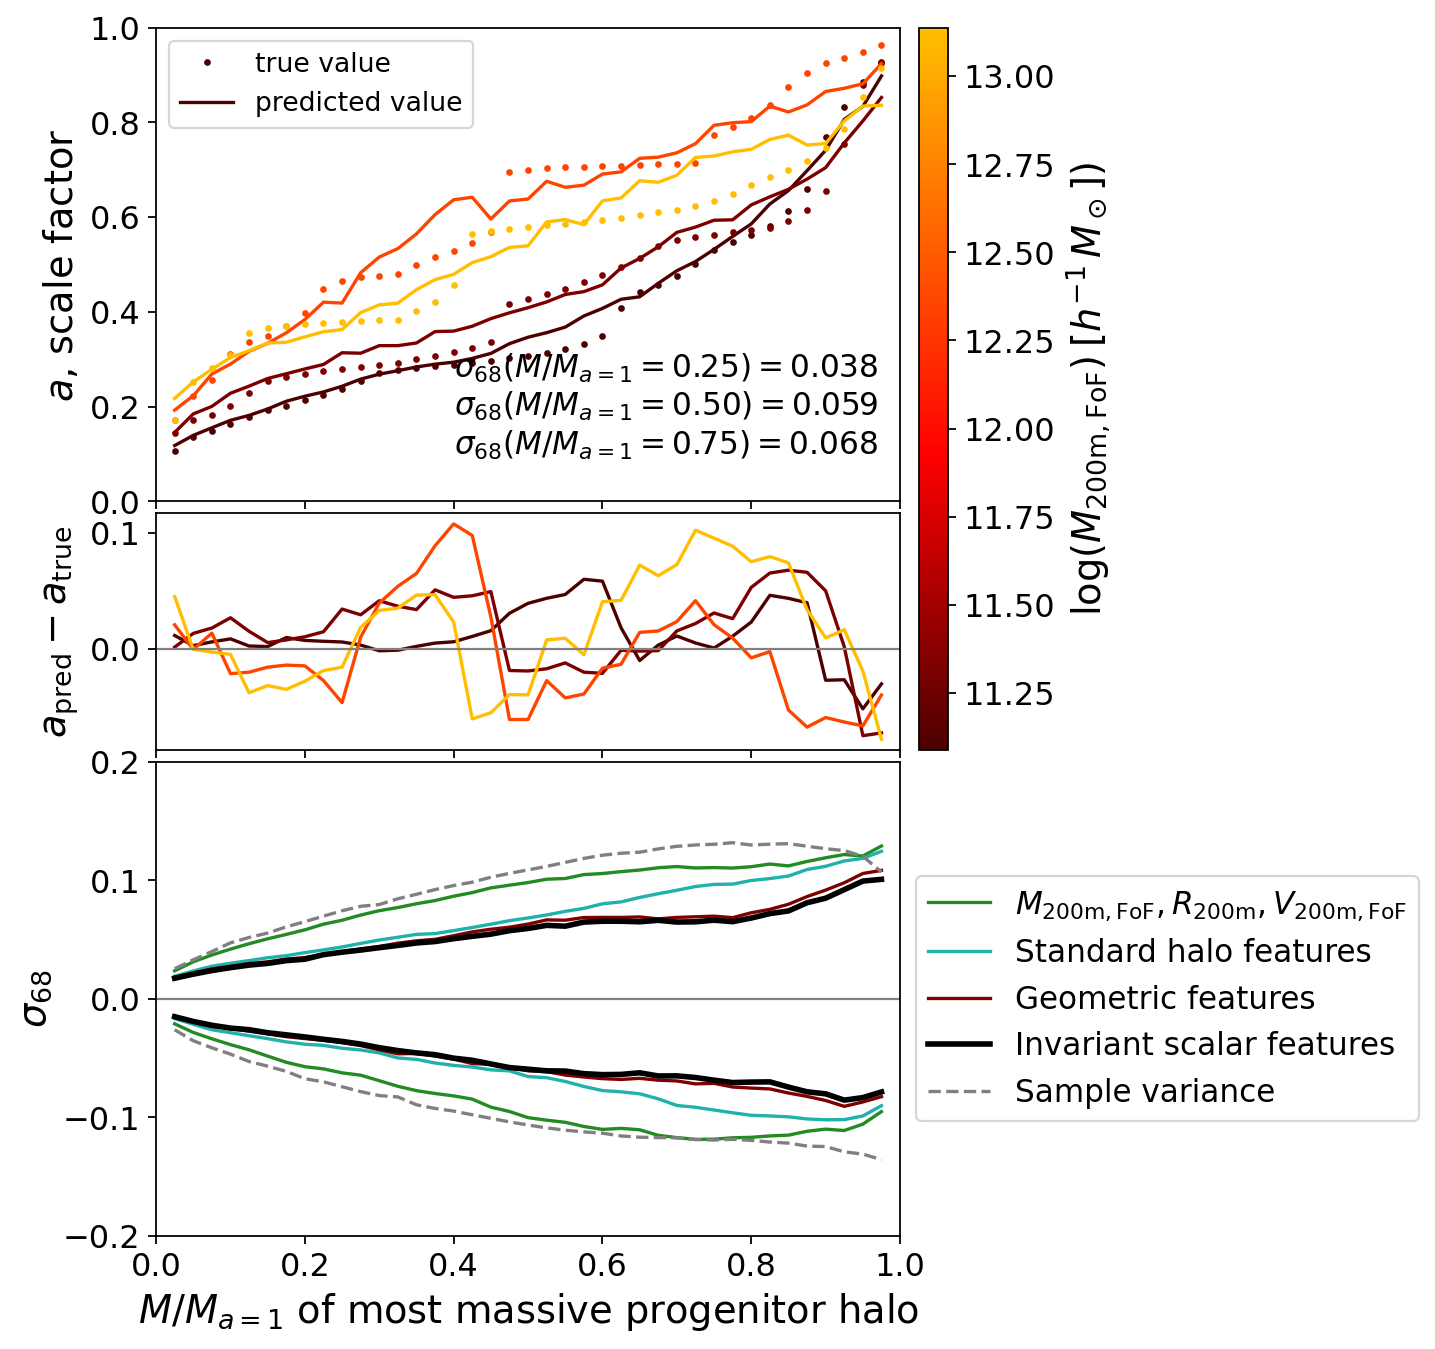

In [263]:
plotter.plot_a_mfrac_accuracy(y_pred_arr, y_test, y_train, mfrac_vals, title='', 
                              idxs_show=idxs_show, xs_show=x_property[idxs_show], label_show=label_show,
                              feature_labels=feature_labels, feature_colors=feature_colors, lws=lws,
                              err_type='percentile', j_fiducial=j_fiducial)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


Bbox(x0=0.125, y0=0.583921568627451, x1=0.9, y1=0.88)
Bbox(x0=0.125, y0=0.42848039215686284, x1=0.9, y1=0.5765196078431374)


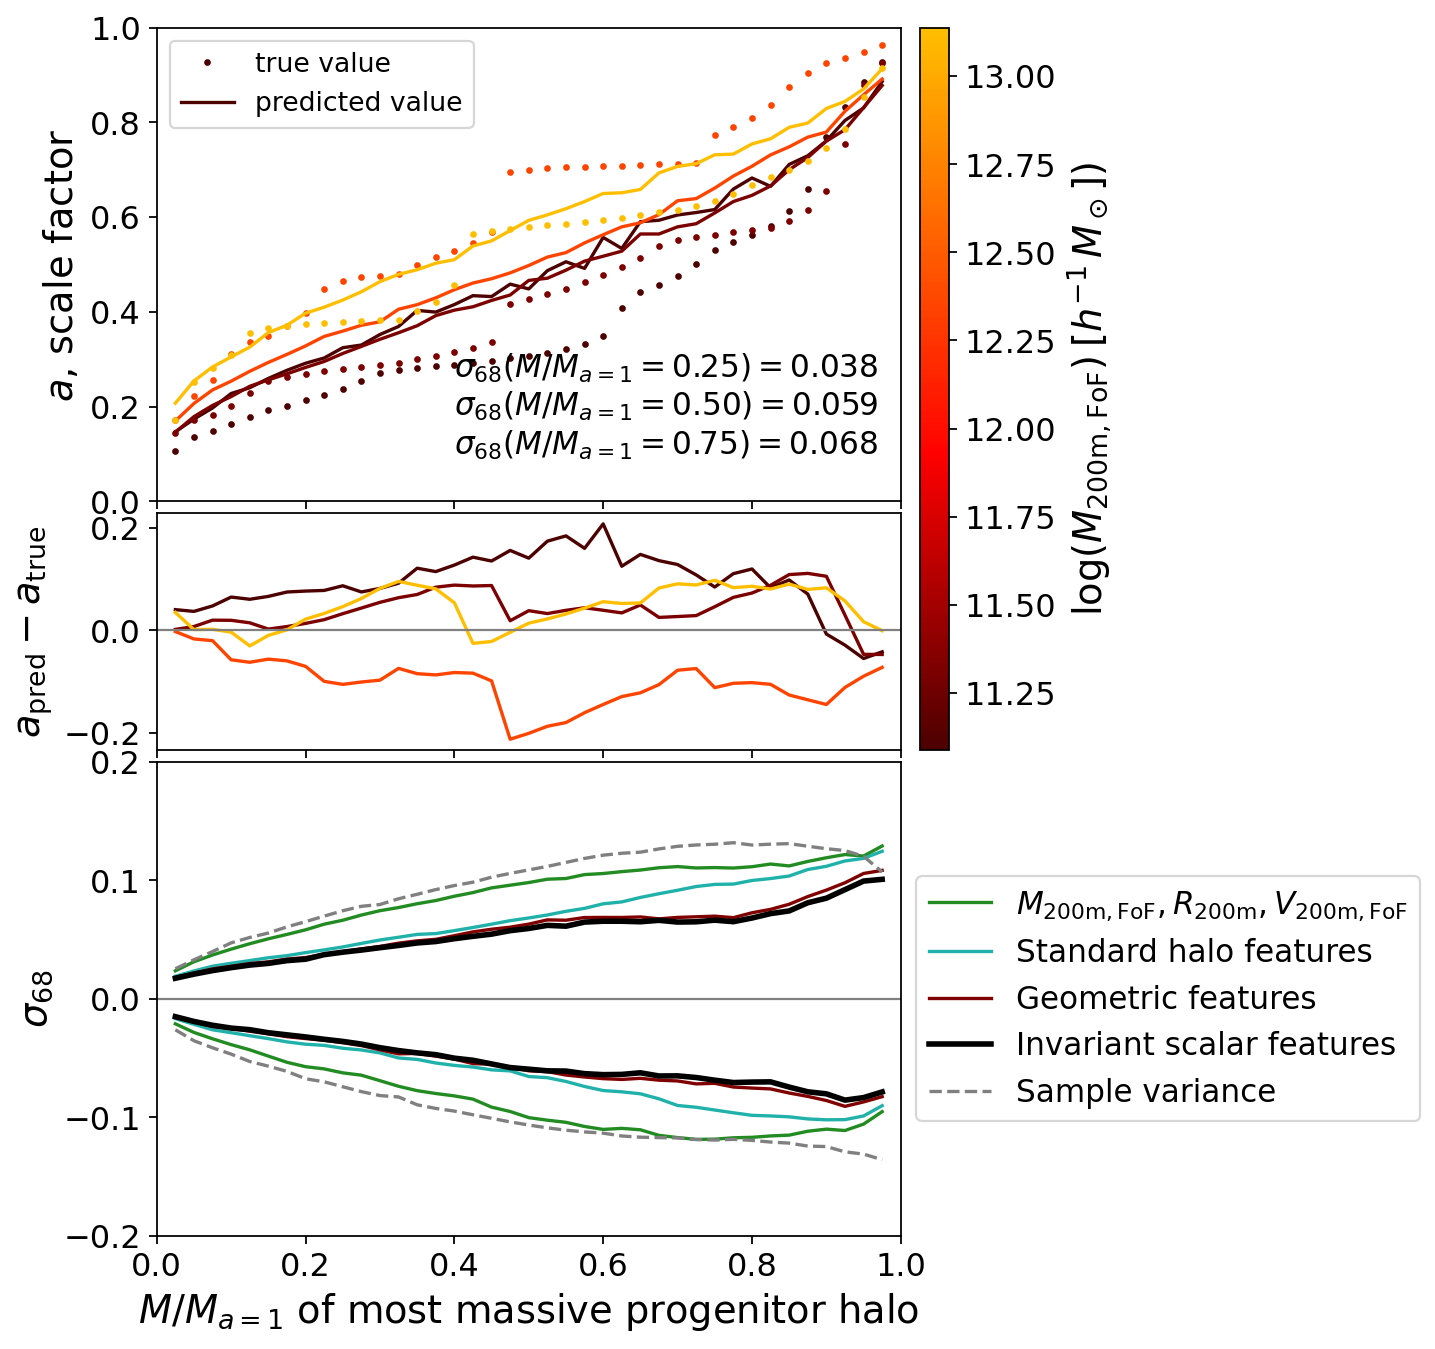

In [267]:
plotter.plot_a_mfrac_accuracy(y_pred_arr, y_test, y_train, mfrac_vals, title='', 
                              idxs_show=idxs_show, xs_show=x_property[idxs_show], label_show=label_show,
                              feature_labels=feature_labels, feature_colors=feature_colors, lws=lws,
                              err_type='percentile', j_fiducial=feature_modes.index('mrv'))

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


Bbox(x0=0.125, y0=0.583921568627451, x1=0.9, y1=0.88)
Bbox(x0=0.125, y0=0.42848039215686284, x1=0.9, y1=0.5765196078431374)


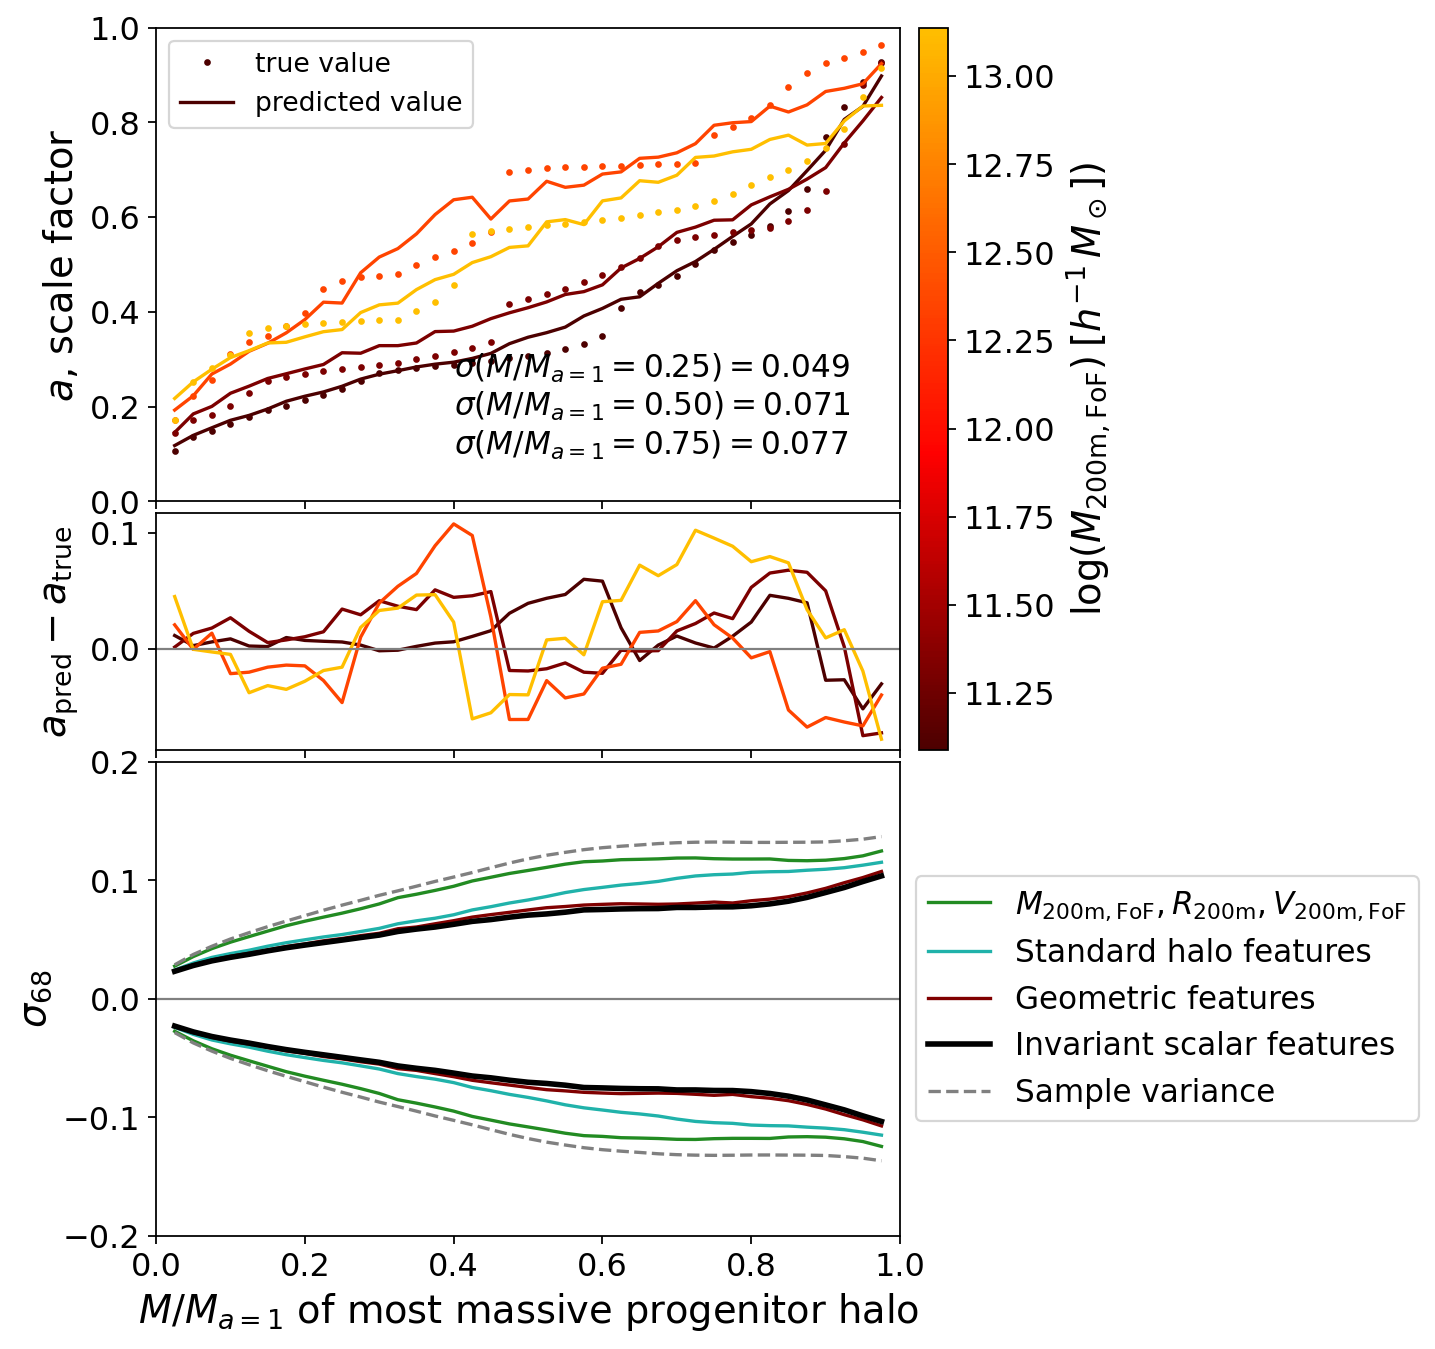

In [268]:
plotter.plot_a_mfrac_accuracy(y_pred_arr, y_test, y_train, mfrac_vals, title='', 
                              idxs_show=idxs_show, xs_show=x_property[idxs_show], label_show=label_show,
                              feature_labels=feature_labels, feature_colors=feature_colors, lws=lws,
                              err_type='stdev', j_fiducial=j_fiducial)

## compare to other feature sets

In [70]:
mfrac_targets = [0.8, 0.6, 0.4]

In [ ]:
lws = np.full(len(feature_modes), 1.5)
lws[j_fiducial] = 2.5

In [71]:
feature_modes = ['mrv', 'catalogz0', 'geos_n3', 'scalars_n3']
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]
j_fiducial = feature_modes.index('scalars_n3')

In [72]:
y_label_arr = []
title_arr = []
y_true_arr = []
y_pred_arr = []

for mfrac_target in mfrac_targets:
    _, idx_mfrac = utils.find_nearest(mfrac_vals, mfrac_target)
    y_test_mtarget = y_test[:,idx_mfrac]
    y_true_arr.append(y_test_mtarget)

    y_pred_mtarget_arr = []
    for i, feature_mode in enumerate(feature_modes):
        fit_tag = f'_{feature_mode}_{y_label_name}{model_tag}'
        fn_pred = f'../predictions/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
        y_pred = np.load(fn_pred)
        y_pred_mtarget_arr.append(y_pred[:,idx_mfrac])    
    
    y_pred_arr.append(y_pred_mtarget_arr)
    y_label_arr.append( rf'$a(M/M_{{a=1}})$')
    title_arr.append(rf'$M/M_{{a=1}} = {mfrac_target}$')

y_pred_arr = np.array(y_pred_arr)
y_true_arr = np.array(y_true_arr)
print(y_pred_arr.shape)
print(y_true_arr.shape)

(3, 4, 4696)
(3, 4696)


Assuming x bins are log !
Assuming x bins are log !
Assuming x bins are log !


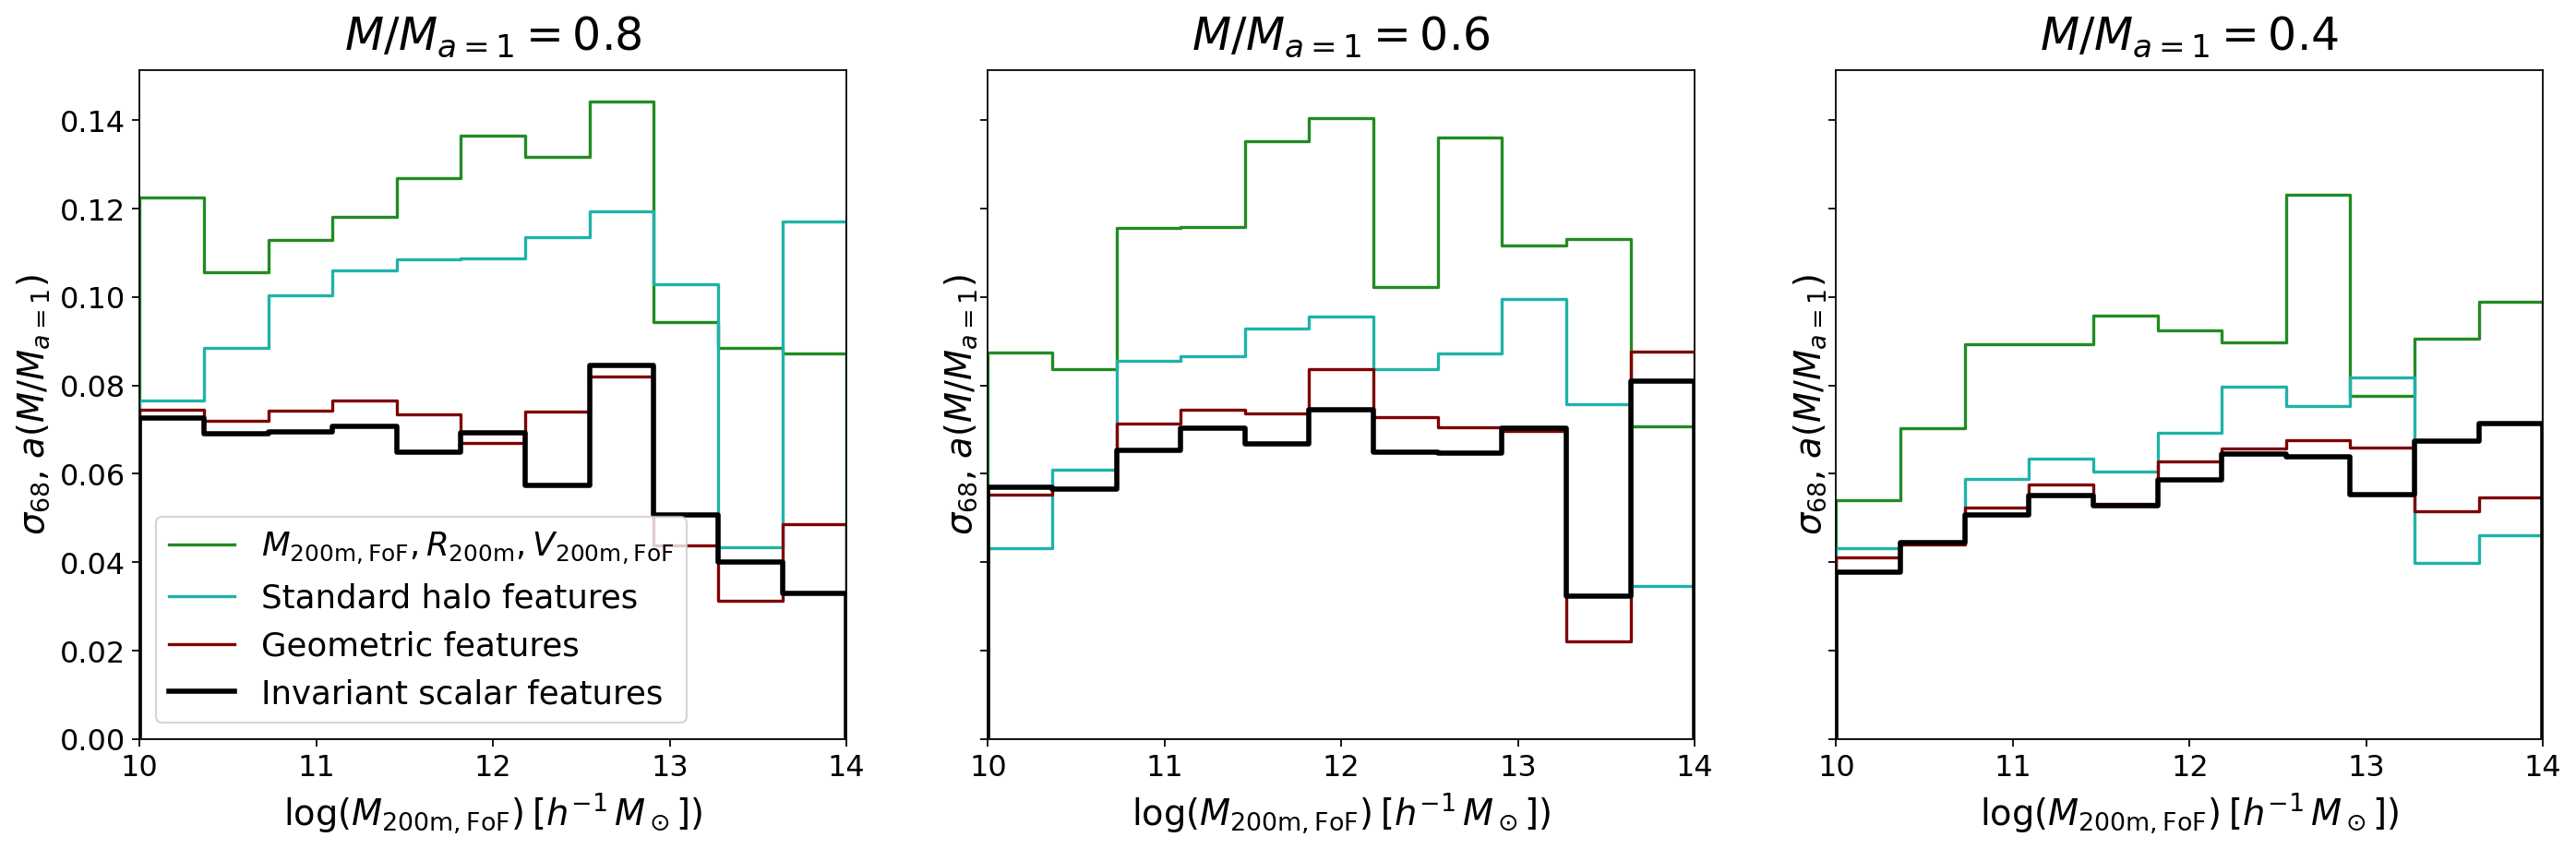

In [88]:
x_label_name = 'log_m200m_fof'
x_property = tab_halos_select[x_label_name][idx_test]
plotter.plot_amfracs(x_label_name, y_label_arr, x_property, 
                 y_true_arr, y_pred_arr, mfrac_vals,
                 feature_labels, feature_colors, lws=lws, j_fiducial=0, title_arr=title_arr,
                 )
fn = f'{plot_dir}/pred_amfracs_multi.png'
if save:
    plt.savefig(fn, bbox_inches='tight')